<a href="https://colab.research.google.com/github/sownther-05/Cutaneous_disorder_detection-uisng-CNN/blob/main/CUTANEOUS_DISORDER_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'dermnet:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F735911%2F1276317%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240403%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240403T214817Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3De671de66d5707b6e94db87a583bd69d20977916ddcec0c2992752496354441aee552ed114a0245386939e779c85710a82d6fa578ffec854881eabf3438d1eebe0b6718e91d26f09b22d7c43ff6a7bd1f4e9ebf9726261b9e450534f9cd2a3877ba5a705d4d734f9aa5237cd0c9a3005b21d8a38f59084afe98fdc9dc68a2098166b52e3f087446ccf25b9ace78e8bfbdfd3378d15d61d5e76d0d986a02df3d2021d74cb01cba9eb13e58ab4514297c10d803e674204d1ba8752b5afffce9cb2179885a368a1098e97bbdd095d2b3efda9cfcc3602b9ce071b41d2fa19b5e8841be2c303ca5fb93f91025987e4f37208661f50e2a6e7b38483db9476bc9ad2077,skindatasets:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2975617%2F5124108%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240403%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240403T214817Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db85e1141c35ebaeed736ff01d5e83f7fe24302698827ad1aa02a2915294fef01bb28539d351307ca9a94673505881f66dd99375c67092db18b31996e8b87882705e0660fccae2ce3ca64d0a5af74778c15ffb16e1451334c1aca2843283c354a41641d9edb64c8263b0d18034c84fc3fc5da83b77f0d9ccac1c7b602f837f995e2e3d7b493c7761c61437d32082608272f3d807e6232b9dfb67706a88ae598ba9569554ab18458604aafa56ae56d4fd2a6e0bb483e24e81005ba3a9bf43b2adbef12cfc6aacb4a4d3fa00e567b386001632280cf763c0f98d22ce7f86413bd84cc3f97b8f0cbdb821f1f89088f62632a2990e6a7a443f39a5c3b5e66609fa78e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1847748564 bytes downloaded
Downloaded and uncompressed: dermnet
[==================================================] 690061360 bytes downloaded
Downloaded and uncompressed: skindatasets
Data source import complete.


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Sequential, Model
from keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten, \
                          Dropout, Input,GlobalAveragePooling2D,BatchNormalization)
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from mpl_toolkits.axes_grid1 import ImageGrid
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix,
                             accuracy_score)
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Sequential, Model
from keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten,
                          Dropout, Input,GlobalAveragePooling2D,BatchNormalization)
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from mpl_toolkits.axes_grid1 import ImageGrid
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix, accuracy_score)`
# Base Libraries
from tensorflow.keras.applications import  VGG19,EfficientNetB0,VGG16,InceptionV3,ResNet50,EfficientNetB3
from tensorflow.keras.models import Model
from keras.applications.vgg16 import preprocess_input
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
# Transformation
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import power_transform
from sklearn.pipeline import Pipeline
# Feature Selection


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


In [ ]:
train2=os.listdir("/kaggle/input/dermnet/train")

In [ ]:
train2

['Poison Ivy Photos and other Contact Dermatitis',
 'Vascular Tumors',
 'Atopic Dermatitis Photos',
 'Acne and Rosacea Photos',
 'Lupus and other Connective Tissue diseases',
 'Melanoma Skin Cancer Nevi and Moles',
 'Herpes HPV and other STDs Photos',
 'Cellulitis Impetigo and other Bacterial Infections',
 'Eczema Photos',
 'Warts Molluscum and other Viral Infections',
 'Nail Fungus and other Nail Disease',
 'Tinea Ringworm Candidiasis and other Fungal Infections',
 'Hair Loss Photos Alopecia and other Hair Diseases',
 'Light Diseases and Disorders of Pigmentation',
 'Scabies Lyme Disease and other Infestations and Bites',
 'Vasculitis Photos',
 'Urticaria Hives',
 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions',
 'Psoriasis pictures Lichen Planus and related diseases',
 'Exanthems and Drug Eruptions',
 'Systemic Disease',
 'Seborrheic Keratoses and other Benign Tumors',
 'Bullous Disease Photos']

In [ ]:
cat2=['Melanoma Skin Cancer Nevi and Moles']

In [ ]:
cat=['Acne and Rosacea Photos',
 'Normal',
 'vitiligo',
 'Tinea Ringworm Candidiasis and other Fungal Infections',
     'Melanoma Skin Cancer Nevi and Moles',
 'Eczema Photos']

In [ ]:
def data_dictionary():
    path_train="/kaggle/input/skindatasets/skin/train/"
    path_test="/kaggle/input/dermnet/train/"
    list_train=cat#os.listdir(path_train)
    list_train1=cat2
    train_dictionary={"image_path":[],"target":[]}
    test_dictionary={"image_path":[],"target":[]}
    k=0
    for i in list_train:
        path_disease_train=path_train+i
        image_list_train=os.listdir(path_disease_train)
        for j in image_list_train:
            img_path_train=path_disease_train+"/"+j
            if img_path_train!="/kaggle/input/skindatasets/skin/train/Normal/34.avif":

                train_dictionary["image_path"].append(img_path_train)
                train_dictionary['target'].append(k)
        k+=1
    for i in list_train1:
        path_disease_test=path_test+i
        image_list_test=os.listdir(path_disease_test)
        for j in image_list_test:
            img_path_train=path_disease_test+"/"+j
            train_dictionary["image_path"].append(img_path_train)
            train_dictionary['target'].append(4)
    train_df=pd.DataFrame(train_dictionary)
    return  train_df

In [ ]:
train=data_dictionary()

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7330 entries, 0 to 7329
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  7330 non-null   object
 1   target      7330 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 114.7+ KB


In [ ]:


import cv2
images=[]
label=[]
for i in train['image_path']:
    if i!="/kaggle/input/skindatasets/skin/train/Normal/34.avif":
        img=cv2.imread(i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img=cv2.resize(img,(180,180))
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #img=cv2.resize(img,(64,64),interpolation=cv2.INTER_AREA)
        #img=resize_and_rescale(img)
        images.append(img)


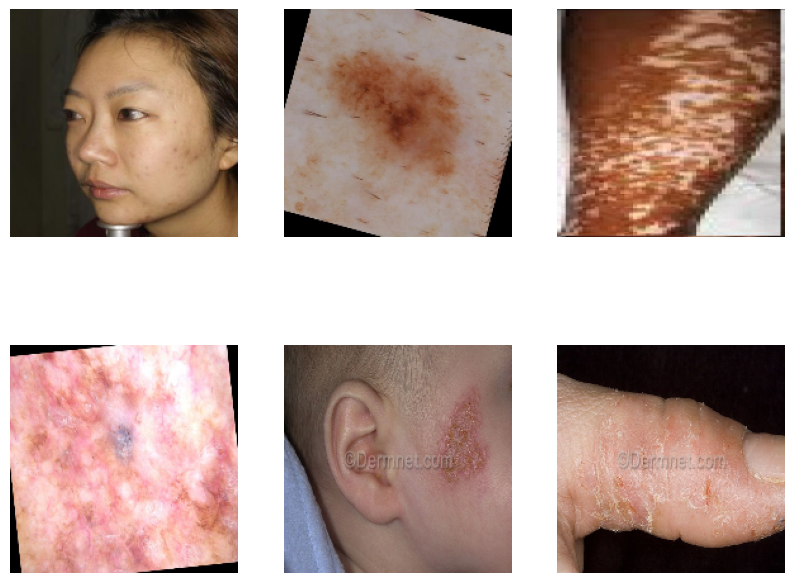

In [ ]:

# Create a list of example inputs to our Gradio demo
example_list = [image for image in random.sample(images, k=6)]

# Plot the images in a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

for ax, img_array in zip(axes.ravel(), example_list):
    ax.imshow(img_array)
    ax.axis('off')

plt.show()


In [ ]:
label=train['target']

In [ ]:
len(label)

7330

In [ ]:
len(images)

7330

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
data=np.array(images)


In [ ]:
label=np.array(label)

In [ ]:
data.shape

(7330, 180, 180, 3)

In [ ]:
label.shape

(7330,)

In [ ]:
!pip install sklearn_relief

In [ ]:
vgg_model = VGG19(weights = 'imagenet',  include_top = False, input_shape = (180, 180, 3))

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
# let's make all layers non-trainable
for layer in vgg_model.layers :
    layer.trainable = False

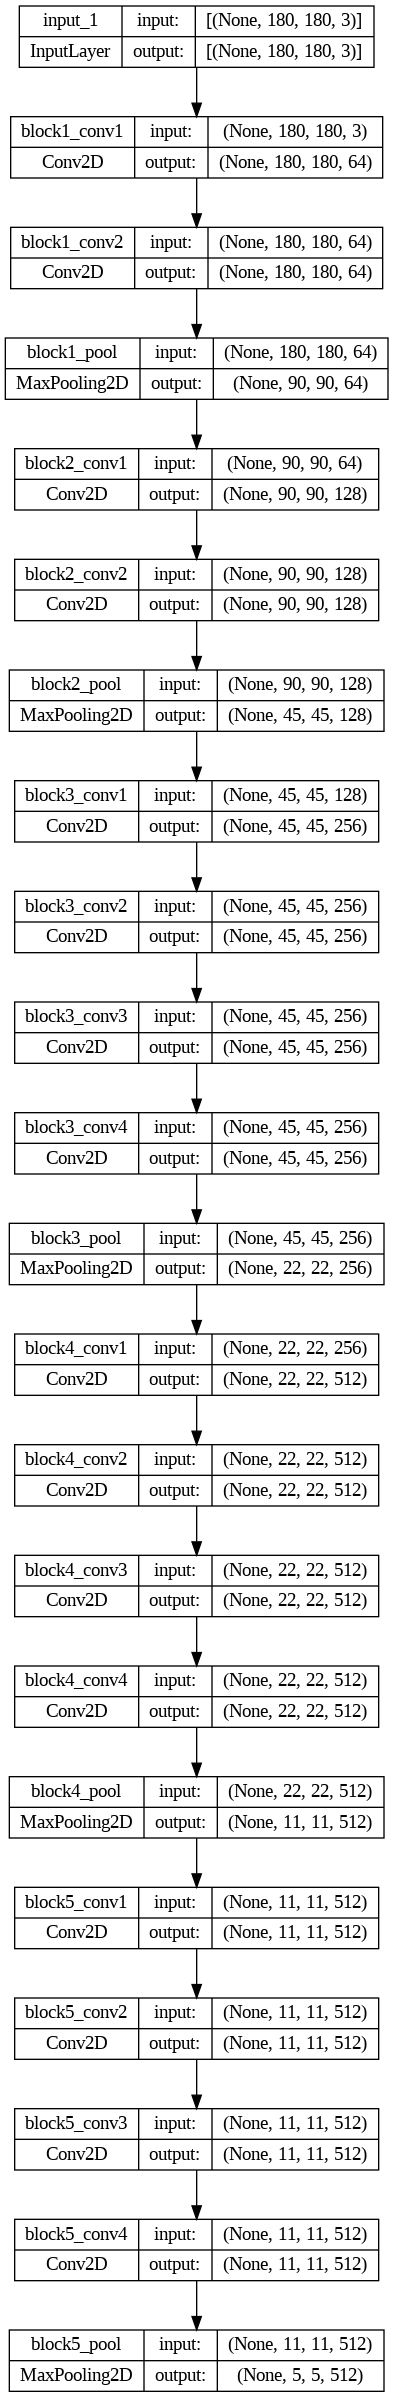

In [ ]:
from tensorflow.keras.utils import plot_model
# Assuming vgg_model is your model's variable name
plot_model(vgg_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten, Dense


In [ ]:
model=Sequential([

                    Dense(200,activation='relu'),
                  Dense(170,activation='relu'),
                  Dense(6,activation='softmax'),

])

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [ ]:
mcp_save = ModelCheckpoint('EnetB0_CIFAR10_TL.h5', save_best_only=True, monitor='val_acc')
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, verbose=1,)

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
kf = KFold(n_splits = 3)

In [ ]:
import keras
acc=[]
num_classes = 6
label = keras.utils.to_categorical(label, num_classes)

In [ ]:
label.shape


(7330, 6)

In [ ]:

for i in range(3):
    x_train,x_test, y_train, y_test=train_test_split(data, label, test_size=0.2,random_state = np.random.randint(1,1000, 1)[0])
    print(x_train.shape)
    # let's make all layers non-trainable
    for layer in vgg_model.layers :
        layer.trainable = False
    features_train=vgg_model.predict(x_train)
    features_test=vgg_model.predict(x_test)
    print(features_train.shape)
    num_train=x_train.shape[0]
    num_test=x_test.shape[0]
    print(num_train)
    print(num_test)
    x_test=features_test.reshape(num_test,-1)
    x_train=features_train.reshape(num_train,-1)
    print(x_train.shape)
    print(x_train.shape)
    #x_train,x_valid,y_train,y_valid= train_test_split(x_train, y_train, test_size=0.1,random_state = np.random.randint(1,1000, 1)[0])
#     history=model.fit(x_train,y_train,epochs=15,batch_size=32,verbose=1)
#     model.evaluate(x_test,y_test)

(5864, 180, 180, 3)
46/46 [==============================] - 9s 200ms/step
(5864, 5, 5, 512)
5864
1466
(5864, 12800)
(5864, 12800)
(5864, 180, 180, 3)
46/46 [==============================] - 5s 112ms/step
(5864, 5, 5, 512)
5864
1466
(5864, 12800)
(5864, 12800)
(5864, 180, 180, 3)
46/46 [==============================] - 5s 117ms/step
(5864, 5, 5, 512)
5864
1466
(5864, 12800)
(5864, 12800)


In [ ]:
history = model.fit(x_train, y_train, epochs=25)


Epoch 1/25
184/184 [==============================] - 3s 4ms/step - loss: 1.6425 - accuracy: 0.6953
Epoch 2/25
184/184 [==============================] - 1s 4ms/step - loss: 0.5003 - accuracy: 0.8453
Epoch 3/25
184/184 [==============================] - 1s 4ms/step - loss: 0.3493 - accuracy: 0.8984
Epoch 4/25
184/184 [==============================] - 1s 4ms/step - loss: 0.2906 - accuracy: 0.9151
Epoch 5/25
184/184 [==============================] - 1s 4ms/step - loss: 0.1943 - accuracy: 0.9425
Epoch 6/25
184/184 [==============================] - 1s 4ms/step - loss: 0.2147 - accuracy: 0.9492
Epoch 7/25
184/184 [==============================] - 1s 4ms/step - loss: 0.2004 - accuracy: 0.9546
Epoch 8/25
184/184 [==============================] - 1s 4ms/step - loss: 0.1383 - accuracy: 0.9661
Epoch 9/25
184/184 [==============================] - 1s 4ms/step - loss: 0.1691 - accuracy: 0.9640
Epoch 10/25
184/184 [==============================] - 1s 4ms/step - loss: 0.2118 - accuracy: 0.9601

In [ ]:
model.save('6claass.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from mlxtend.plotting import plot_confusion_matrix

In [ ]:
y_pred=model.predict(x_test)

46/46 [==============================] - 0s 2ms/step


In [ ]:
y_pred2=np.argmax(y_pred, axis=1)
y_pred2

array([5, 2, 2, ..., 5, 4, 4])

In [ ]:
y_test=np.argmax(y_test, axis=1)

In [ ]:
y_test

array([5, 2, 2, ..., 5, 4, 4])

In [ ]:
confusion_matrix_result=confusion_matrix(y_test,y_pred2)

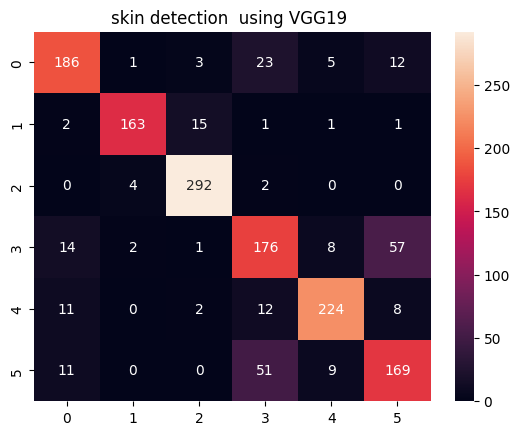

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pylab as pl
plt.title("skin detection  using VGG19 ")

ax= plt.subplot()
sns.heatmap(confusion_matrix_result, annot=True, fmt='g', ax=ax);
pl.show()

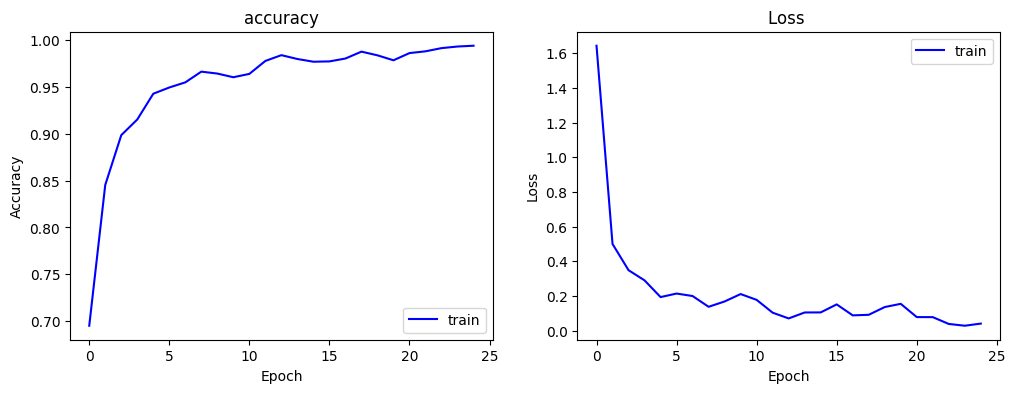

In [ ]:
train_accuracy = history.history['accuracy']
#val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs = range(len(train_accuracy))
plt.figure(figsize=(12,4))
# Plotting the accuracy
plt.subplot(1,2,1)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')

plt.title('accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')

# Plotting the loss
plt.subplot(1,2,2)
plt.plot(epochs, train_loss, 'b', label='Training loss')

plt.title('Loss ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Convolution2D, ZeroPadding2D,MaxPooling2D, Flatten, Dense, Dropout, Activation
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing import image
import pandas as pd
import tensorflow as tf
import keras
import pickle

In [ ]:
confusion_matrix=classification_report(y_test,y_pred2)

In [ ]:
print(confusion_matrix)

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       230
           1       0.96      0.89      0.92       183
           2       0.93      0.98      0.96       298
           3       0.66      0.68      0.67       258
           4       0.91      0.87      0.89       257
           5       0.68      0.70      0.69       240

    accuracy                           0.83      1466
   macro avg       0.83      0.82      0.83      1466
weighted avg       0.83      0.83      0.83      1466



In [ ]:
import tensorflow as tf
import numpy as np
import cv2

import tensorflow as tf
import numpy as np
import cv2

def predict_skin_disease(image_path):
    # Load saved model
    model = tf.keras.models.load_model('6claass.h5')

    # Load and preprocess image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (180, 180))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    img=vgg_model.predict(img)
    img=img.reshape(1,-1)

    # Make prediction on preprocessed image
    pred = model.predict(img)[0]
    predicted_class = np.argmax(pred)

    return predicted_class


print(predict_skin_disease("/kaggle/input/skindatasets/skin/test/Normal/0_0_aidai_0029.jpg"))

1/1 [==============================] - 0s 76ms/step
2


In [ ]:
print(y_train)

[[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]]


In [ ]:
import tensorflow as tf
import numpy as np
import cv2

def predict_skin_disease(image_path):
    # Define list of class names
    class_names = ["Acne","Eczema","Atopic","Psoriasis","Tinea","vitiligo"]

    # Load saved model
    model = tf.keras.models.load_model('6claass.h5')

    # Load and preprocess image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (180, 180))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    img = vgg_model.predict(img)
    img = img.reshape(1, -1)

    # Make prediction on preprocessed image
    pred = model.predict(img)[0]
    predicted_class_index = np.argmax(pred)
    predicted_class_name = class_names[predicted_class_index]

    return predicted_class_name

print(predict_skin_disease("/kaggle/input/dermnet/test/Atopic Dermatitis Photos/03ichthyosis050127.jpg"))


1/1 [==============================] - 0s 45ms/step
Atopic


In [ ]:
import tensorflow as tf

# Load the saved Keras model
model = tf.keras.models.load_model('6claass.h5')

# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Optional: Enable optimization
tflite_model = converter.convert()

# Save the TensorFlow Lite model to file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


In [ ]:
from google.colab import files

# Download the TensorFlow Lite model to your local machine
files.download('model.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>